<a href="https://colab.research.google.com/github/RolandTapie/Data_Projects/blob/main/Data_science/Bank/Bank_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fonction

In [424]:
def summary(liste,section,libelle,valeur):
  liste.append([len(liste)+1,section,libelle,valeur])
  return (liste)

def print_summary(data):
  headers = data[0]
  table_data = data[1:]
  titre="RESULTATS: analyses et Modélisation"
  titre=titre.center(100,"=")
  print("*"* len(titre))
  print(titre)
  print("*"* len(titre))
  print(tabulate(table_data, headers, tablefmt="grid"))

  table_str = titre + "\n" +tabulate(table_data, headers, tablefmt="grid")

  output_file = "/content/drive/My Drive/colab_table_a4_format.txt"

  # Write the formatted table to a .txt file
  with open(output_file, "w") as file:
      file.write(table_str)

  print(f"Table saved to {output_file}")


**Import des packages**

In [425]:
#!pip install nxviz
!pip install fpdf

In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
#import nxviz as nv
import missingno as msno
from itertools import combinations
from tabulate import tabulate
from google.colab import drive
import os
from fpdf import FPDF
# Mount Google Drive
drive.mount('/content/drive')


from scipy.stats import iqr, shapiro
from sklearn.metrics import mean_squared_error, r2_score,roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import qqplot
import numpy as np


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Montage du drive**

In [427]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


**Lecture du dataset**

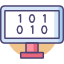

In [428]:
fraction=0.3
seed=42
file_path="https://raw.githubusercontent.com/RolandTapie/Data_Projects/refs/heads/main/Data_science/Datasets/bank_cleaned.csv"
file_path="https://raw.githubusercontent.com/RolandTapie/Data_Projects/refs/heads/main/Data_science/Datasets/titanic_data_simplified.csv"
cible="response_binary"
cible="Survived"

In [429]:

df = pd.read_csv(file_path)
resume=[]
resume=summary(resume,"Section","libelle","information")
resume=summary(resume,"Dataset","Path",file_path)

In [430]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Survived  714 non-null    int64 
 1   Sex       714 non-null    int64 
 2   Pclass    714 non-null    int64 
 3   Age       714 non-null    int64 
 4   Emoji     714 non-null    object
dtypes: int64(4), object(1)
memory usage: 28.0+ KB
None


**Renommage des colonnes**

In [431]:

feat=['age', 'job', 'marital', 'education', 'default','balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign','pdays', 'previous', 'poutcome', 'response_binary']
feat=['age', 'balance','duration', 'campaign','pdays','loan']
one_hot_enconding=["job","marital","education","default","housing","loan","month","poutcome"]
one_hot_enconding=['loan']


**Définir la cible**

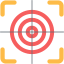

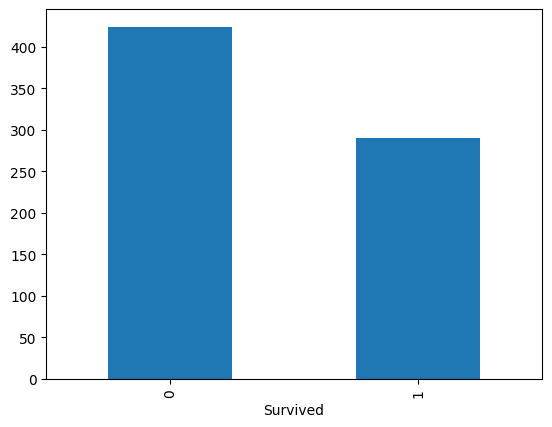

2


In [432]:

df_cible=df[cible].value_counts()
df_cible.plot(kind="bar")
plt.show()
print(len(df_cible))
if (len(df_cible)==2):
  resume=summary(resume,"Dataset","Nature cible", "Cible binaire -> Classification")
elif (len(df_cible)>2):
  resume=summary(resume,"Dataset","Nature cible", "Cible non binaire -> Régression")
else:
  resume=summary(resume,"Dataset","Nature cible", "Vérifier la cible")
  raise ValueError("Vérifier la cible")

**Description du dataset**

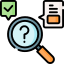

In [433]:
df.describe()
resume=summary(resume,"Dataset","taille", str(len(df)) + " observations")

In [434]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Survived  714 non-null    int64 
 1   Sex       714 non-null    int64 
 2   Pclass    714 non-null    int64 
 3   Age       714 non-null    int64 
 4   Emoji     714 non-null    object
dtypes: int64(4), object(1)
memory usage: 28.0+ KB


**Traiter le type des données**

In [435]:
for col in df.columns:
  if "Unnamed" in col:
    df=df.drop(col,axis=1)
  if "Emoji" in col:
    df=df.drop(col,axis=1)

colonnes=df.columns.tolist()

print("Les champs du Dataset")
print(colonnes)
compteur=0
for col in colonnes:
  if df[col].dtype=="object":
    df[col]=df[col].astype("category")
    compteur+=1

    print(f'les données du champ {col} de type {df[col].dtype} ont été changées en type category')
    print('\n')
    print('Avec les valeurs ci-dessous:')
    print('\n')
    print(df[col].unique())
    print('\n')
resume=summary(resume,"Dataset","Nombre de champs de type object tranformés en category",compteur)

liste_cat=[col for col in df.columns if df[col].dtype=="category"]

resume=summary(resume,"Dataset","Nombre de champs de type category",compteur)
liste_float_int=[col for col in df.columns if ((df[col].dtype=="int64")|(df[col].dtype=="float64"))]

print("*"*100)
print('la liste des champs de type float ou int')
print (liste_float_int)
resume=summary(resume,"Dataset","champs de type float ou int",(liste_float_int))
print("*"*100)
print('la liste des champs de type category')
print (liste_cat)
resume=summary(resume,"Dataset","champs de type category",(liste_cat))

Les champs du Dataset
['Survived', 'Sex', 'Pclass', 'Age']
****************************************************************************************************
la liste des champs de type float ou int
['Survived', 'Sex', 'Pclass', 'Age']
****************************************************************************************************
la liste des champs de type category
[]


**Vérification des enrigistrements nulls**

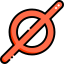

In [436]:
df.isna().any().sum()
resume=summary(resume,"Dataset","Nombre de valeurs nulles",df.isna().any().sum())

**Vérification des doublons**

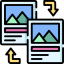

In [437]:
df.duplicated().sum()
resume=summary(resume,"Dataset","Nombre de doublons",df.duplicated().sum())

<Axes: >

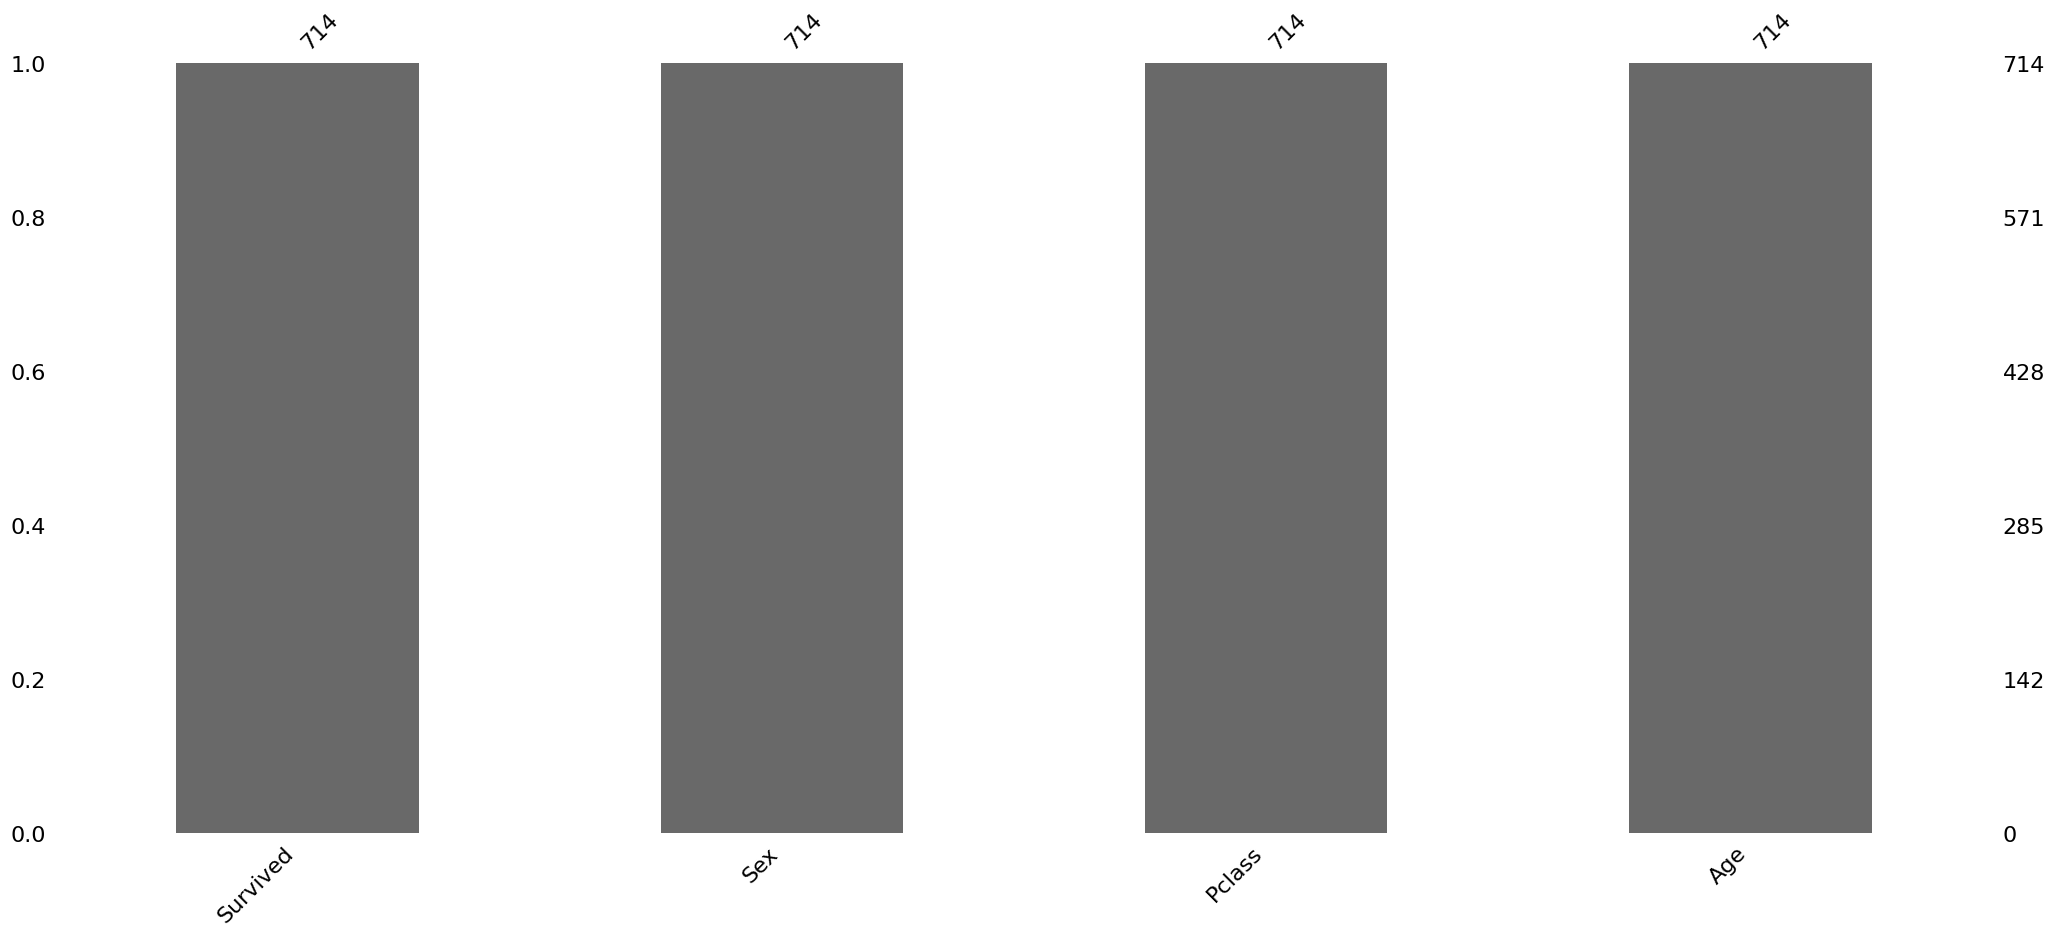

In [438]:
msno.bar(df)

<Axes: >

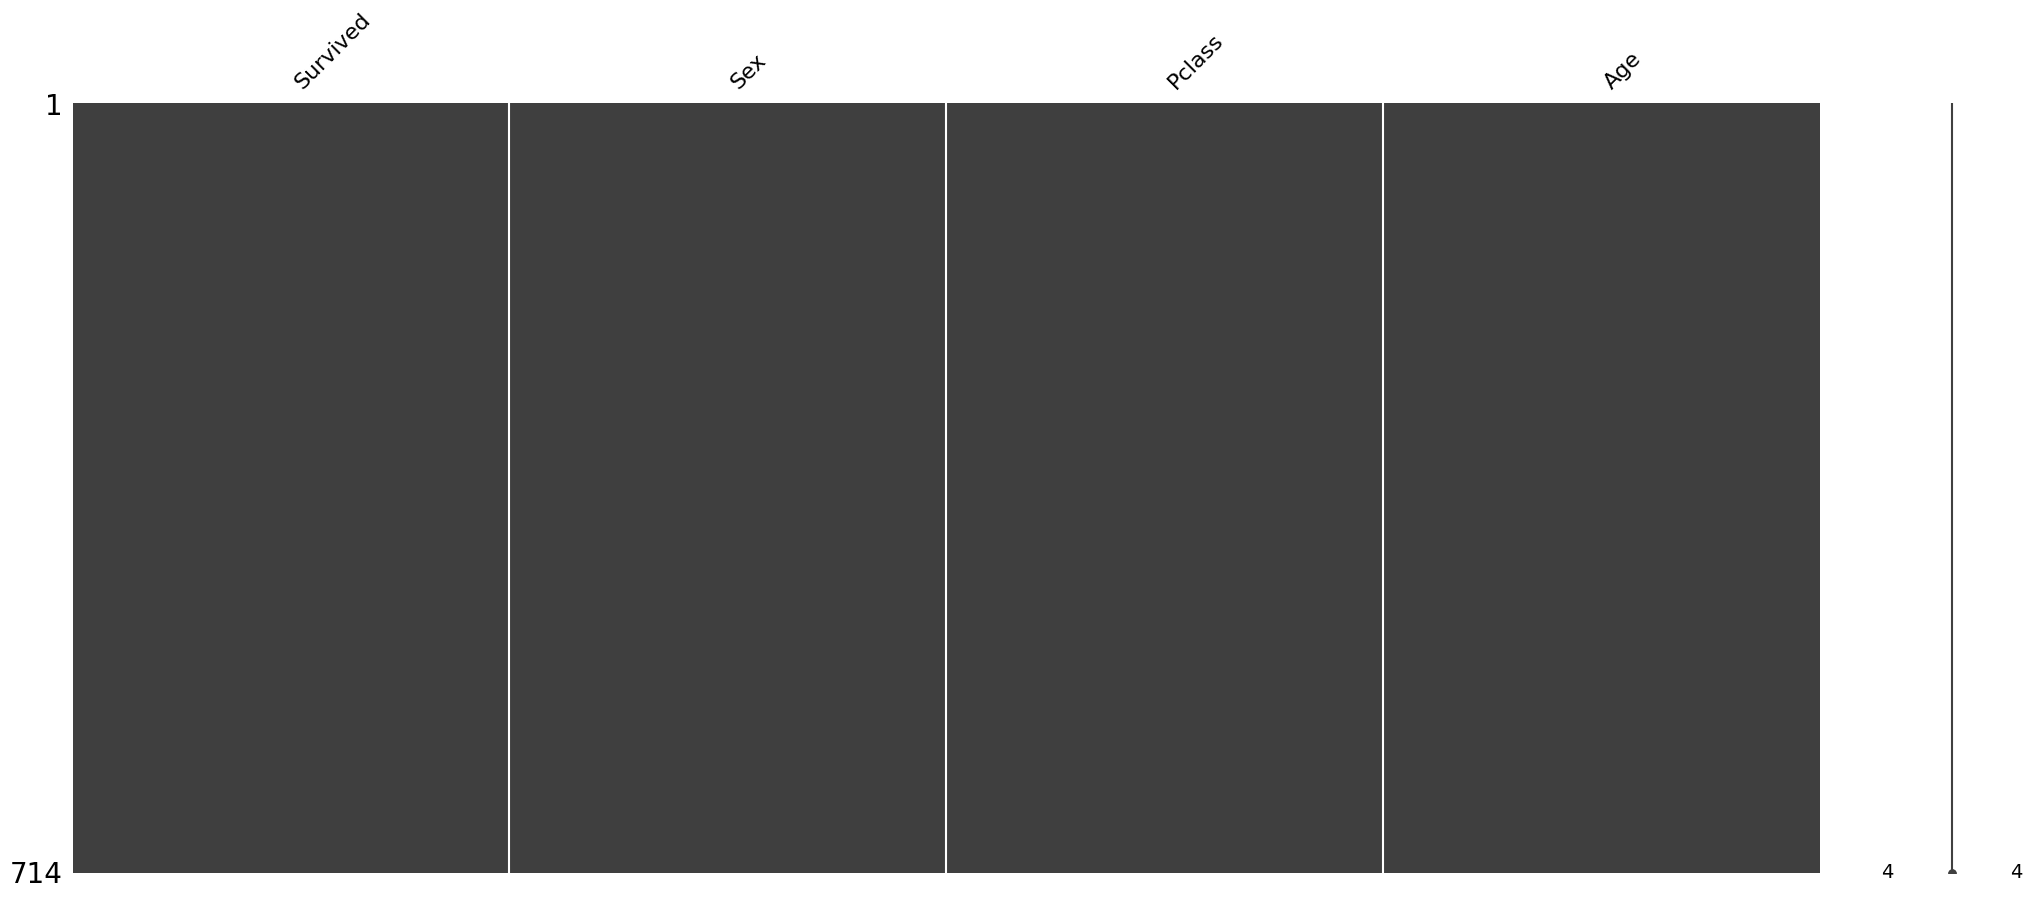

In [439]:
msno.matrix(df)


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Axes: >

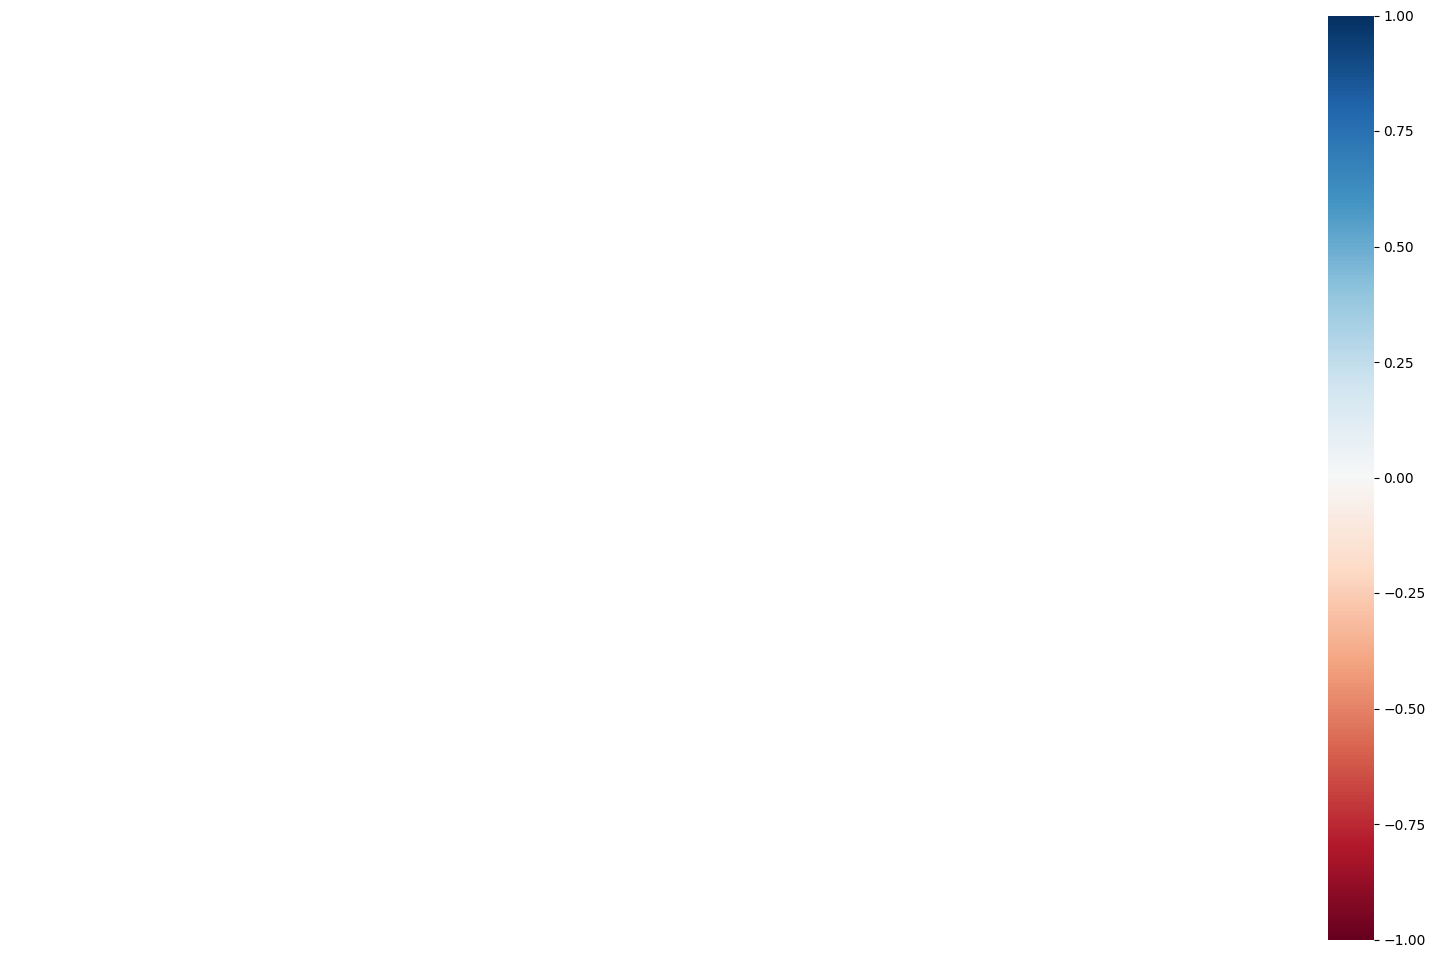

In [440]:
msno.heatmap(df)

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:2821: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([dvw, 0])


<Axes: >

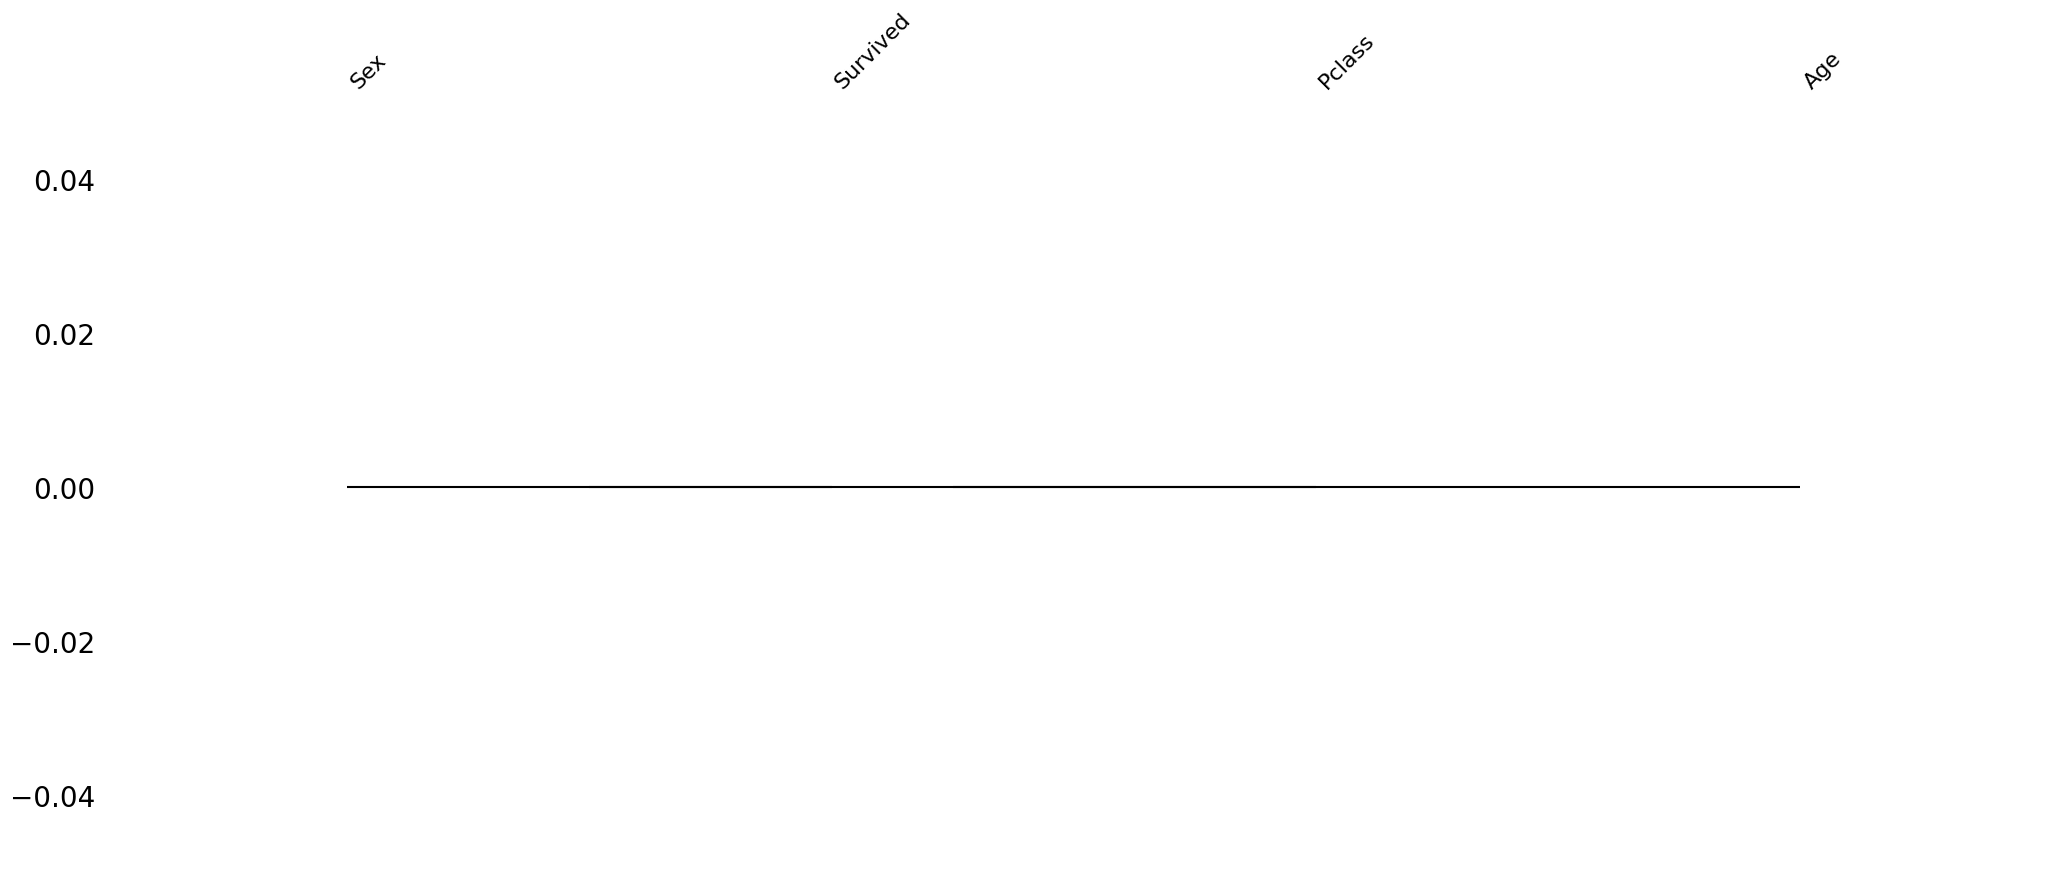

In [441]:
msno.dendrogram(df)

In [442]:
# Supprimer les lignes où toutes les valeurs sont manquantes
df= df.dropna(how='all')

# **EDA**

**Analyse des données catégorielles**

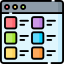

In [443]:
df_cat=df[liste_cat]
analyse=""
for col in liste_cat:
  #print(df_cat[col].value_counts(normalize=True))
  analyse=analyse+col+'\n'
  analyse=analyse+("*"*10)+'\n'
  analyse=analyse+str(df_cat[col].value_counts(normalize=True).round(2))+'\n'
  df_cat[col].value_counts(normalize=True).plot(kind='bar')
  plt.show()
  print("*"*100)
  print(df_cat[col].value_counts(normalize=True).round(2))
resume=summary(resume,"EDA","Analyse des données catégorielles",analyse)

**Vérifications des distributions**



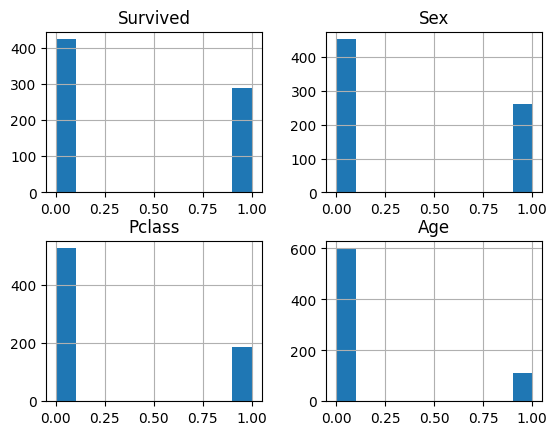

In [444]:
df_num=df[liste_float_int]
df_num.hist()
plt.show()

Test sur la normalité des données numériques

Vérification visuelle pour le champ Survived
Survived 0.624 0.0
Vérification visuelle pour le champ Sex
Sex 0.61 0.0
Vérification visuelle pour le champ Pclass
Pclass 0.547 0.0
Vérification visuelle pour le champ Age
Age 0.438 0.0


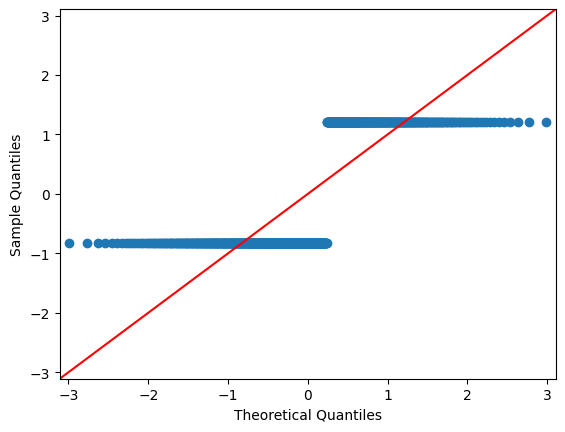

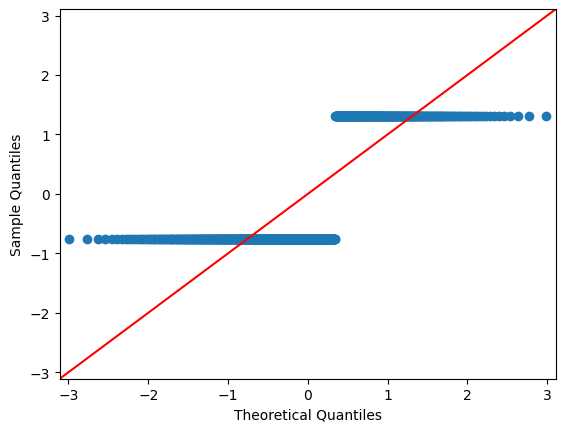

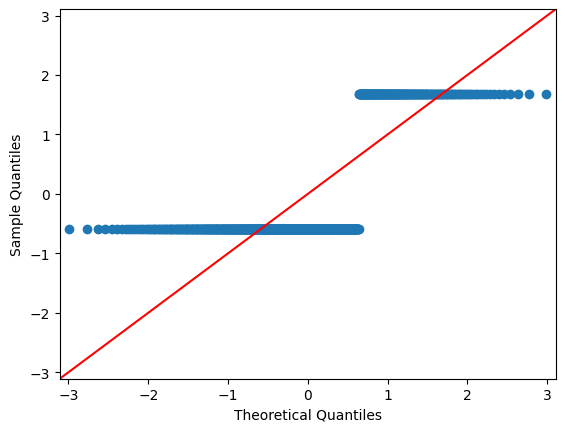

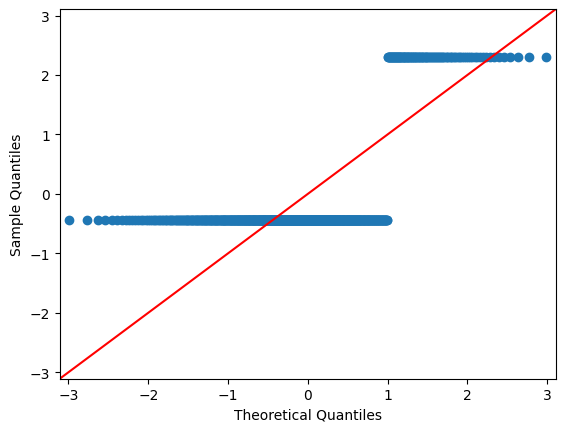

In [445]:
alpha=0.05

liste_norm=""
for col in liste_float_int:
  stats, p_value = shapiro(df[col])
  stats=round(stats,3)
  p_value=round(p_value,3)
  print(f"Vérification visuelle pour le champ {col}")
  qqplot(df[col], fit=True, line="45")
  if p_value>alpha:
    liste_norm=liste_norm+col+f" : p_value ({p_value} > alpha ({alpha})) Non rejet de H0 > les données suivent une distribution normale"+'\n'
  else:
    liste_norm=liste_norm+col+f" : p_value ({p_value} < alpha ({alpha})) Rejet de H0 > les données ne suivent pas une distribution normale"+'\n'
  print(col,stats, p_value)

resume=summary(resume,"EDA","Distribution normale des données (Test de Shapiro Wilk)",f"Mise en place des hypothèses (alpha) = {(alpha)}:" +"\n" \
               + "H0 > (les données suivent une distribution normale)" +"\n"+ "H1 > (les données ne suivent pas une distribution normale) \n"\
               +"\n"\
               + liste_norm)

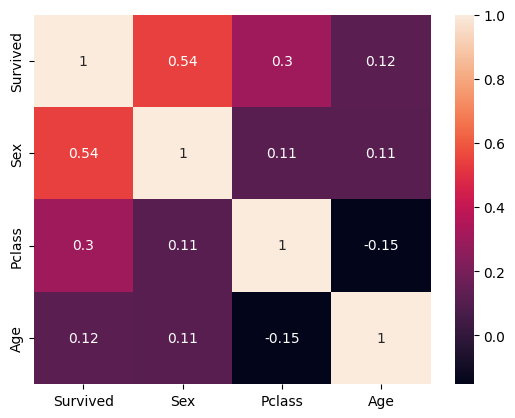

****************************************************************************************************
Liste des corrélations à analyser
****************************************************************************************************
Survived > Sex : 0.539
Sex > Survived : 0.539


In [446]:
df_corr=df_num.corr()
sns.heatmap(df_corr,annot=True)
plt.show()
corr_limit=0.4
liste=[]
corr_check=[]
for i in range(len(df_corr)):
  for j in range(len(df_corr)):
    if (abs(df_corr.iloc[i,j])>=corr_limit)&(i!=j):
        corr_check.append((str(df_corr.columns[i])+ " > " + str(df_corr.columns[j])+ " : " + str(round(df_corr.iloc[i,j],3))))

print("*"*100)
print("Liste des corrélations à analyser")
print("*"*100)
for cor in corr_check:
  print(cor)

resume=summary(resume,"EDA","corrélations à analyser",(corr_check))

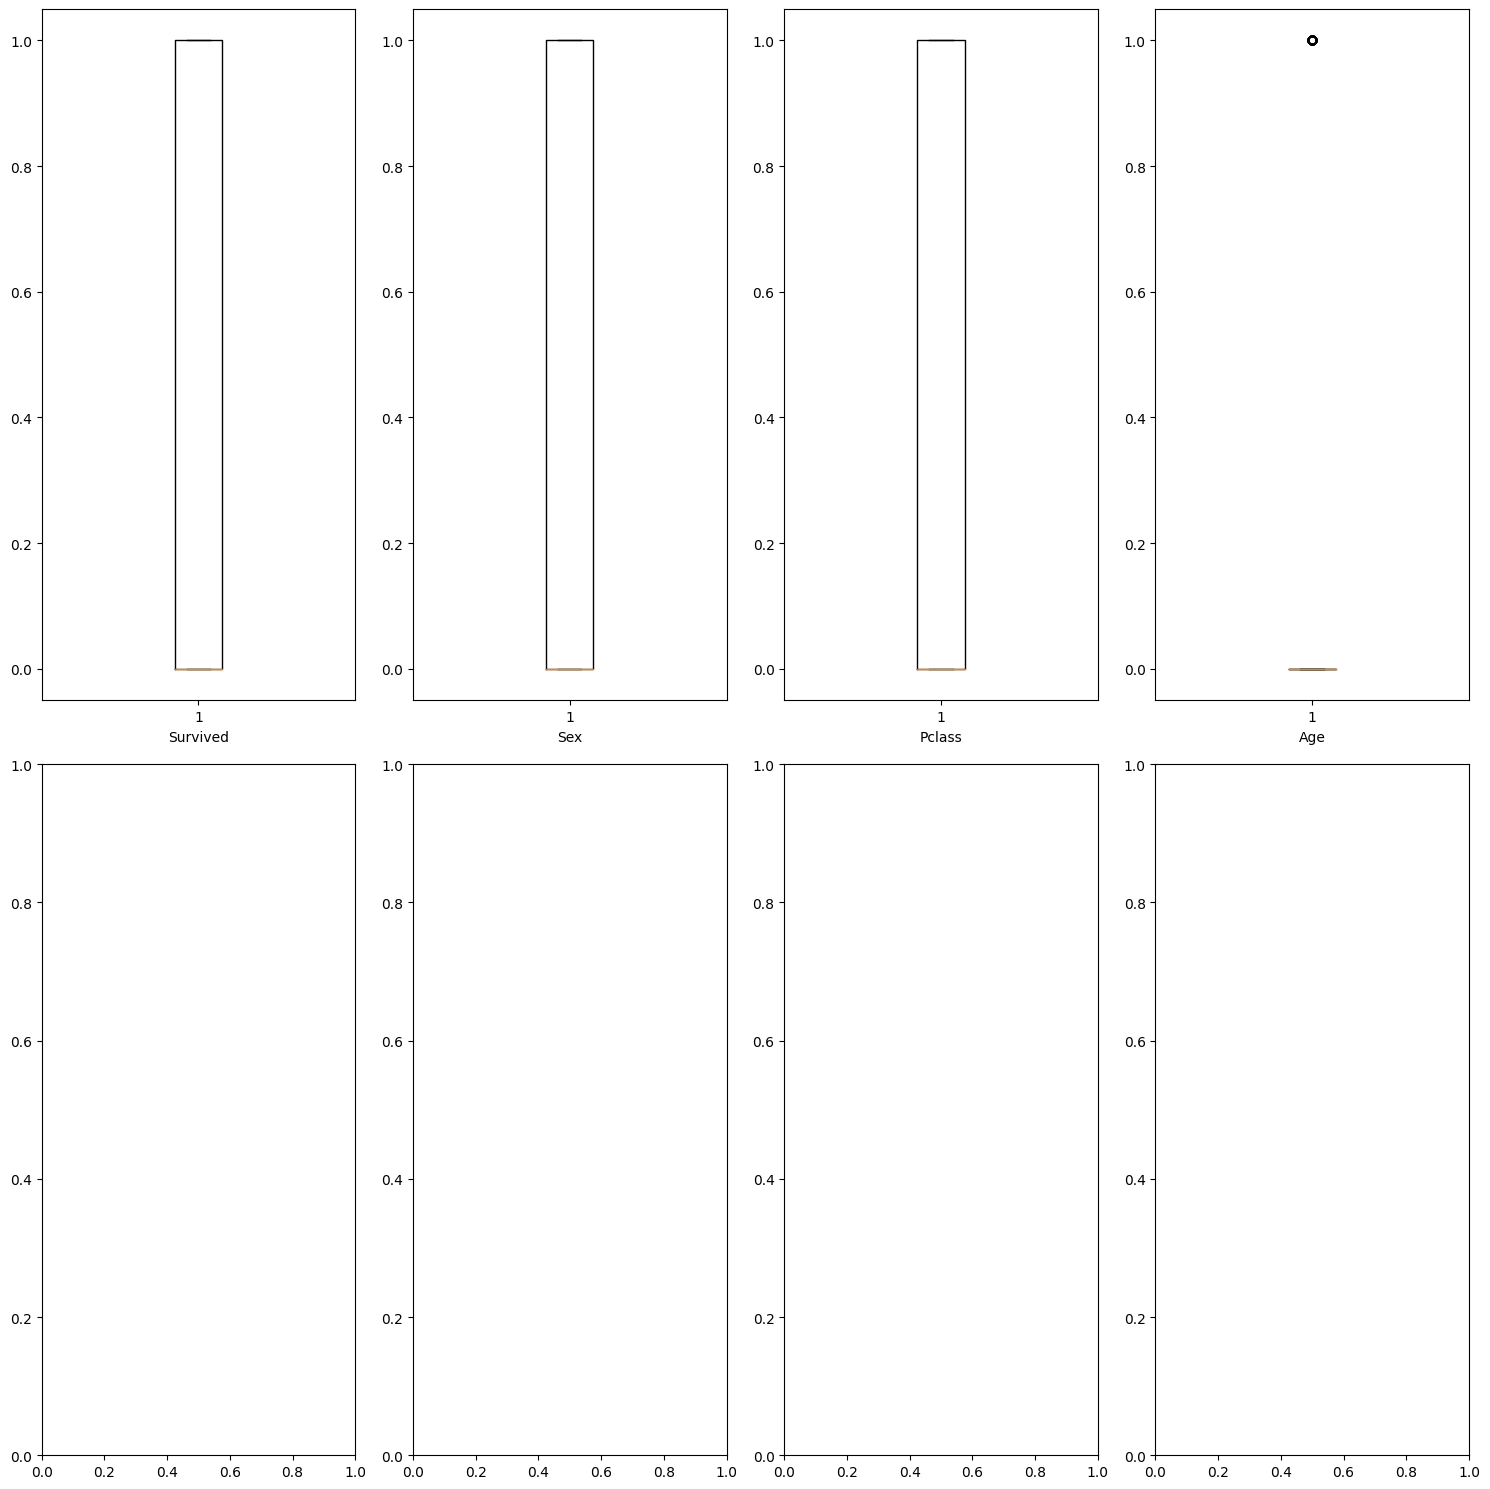

In [447]:
size=len(liste_float_int)
fig, axes = plt.subplots((size//4)+1, 4, figsize=(15, 15))
axes=axes.flatten()
for i, cols in enumerate(liste_float_int):
  axes[i].boxplot(df[cols])
  axes[i].set_xlabel(cols)
plt.tight_layout()
plt.show()

6


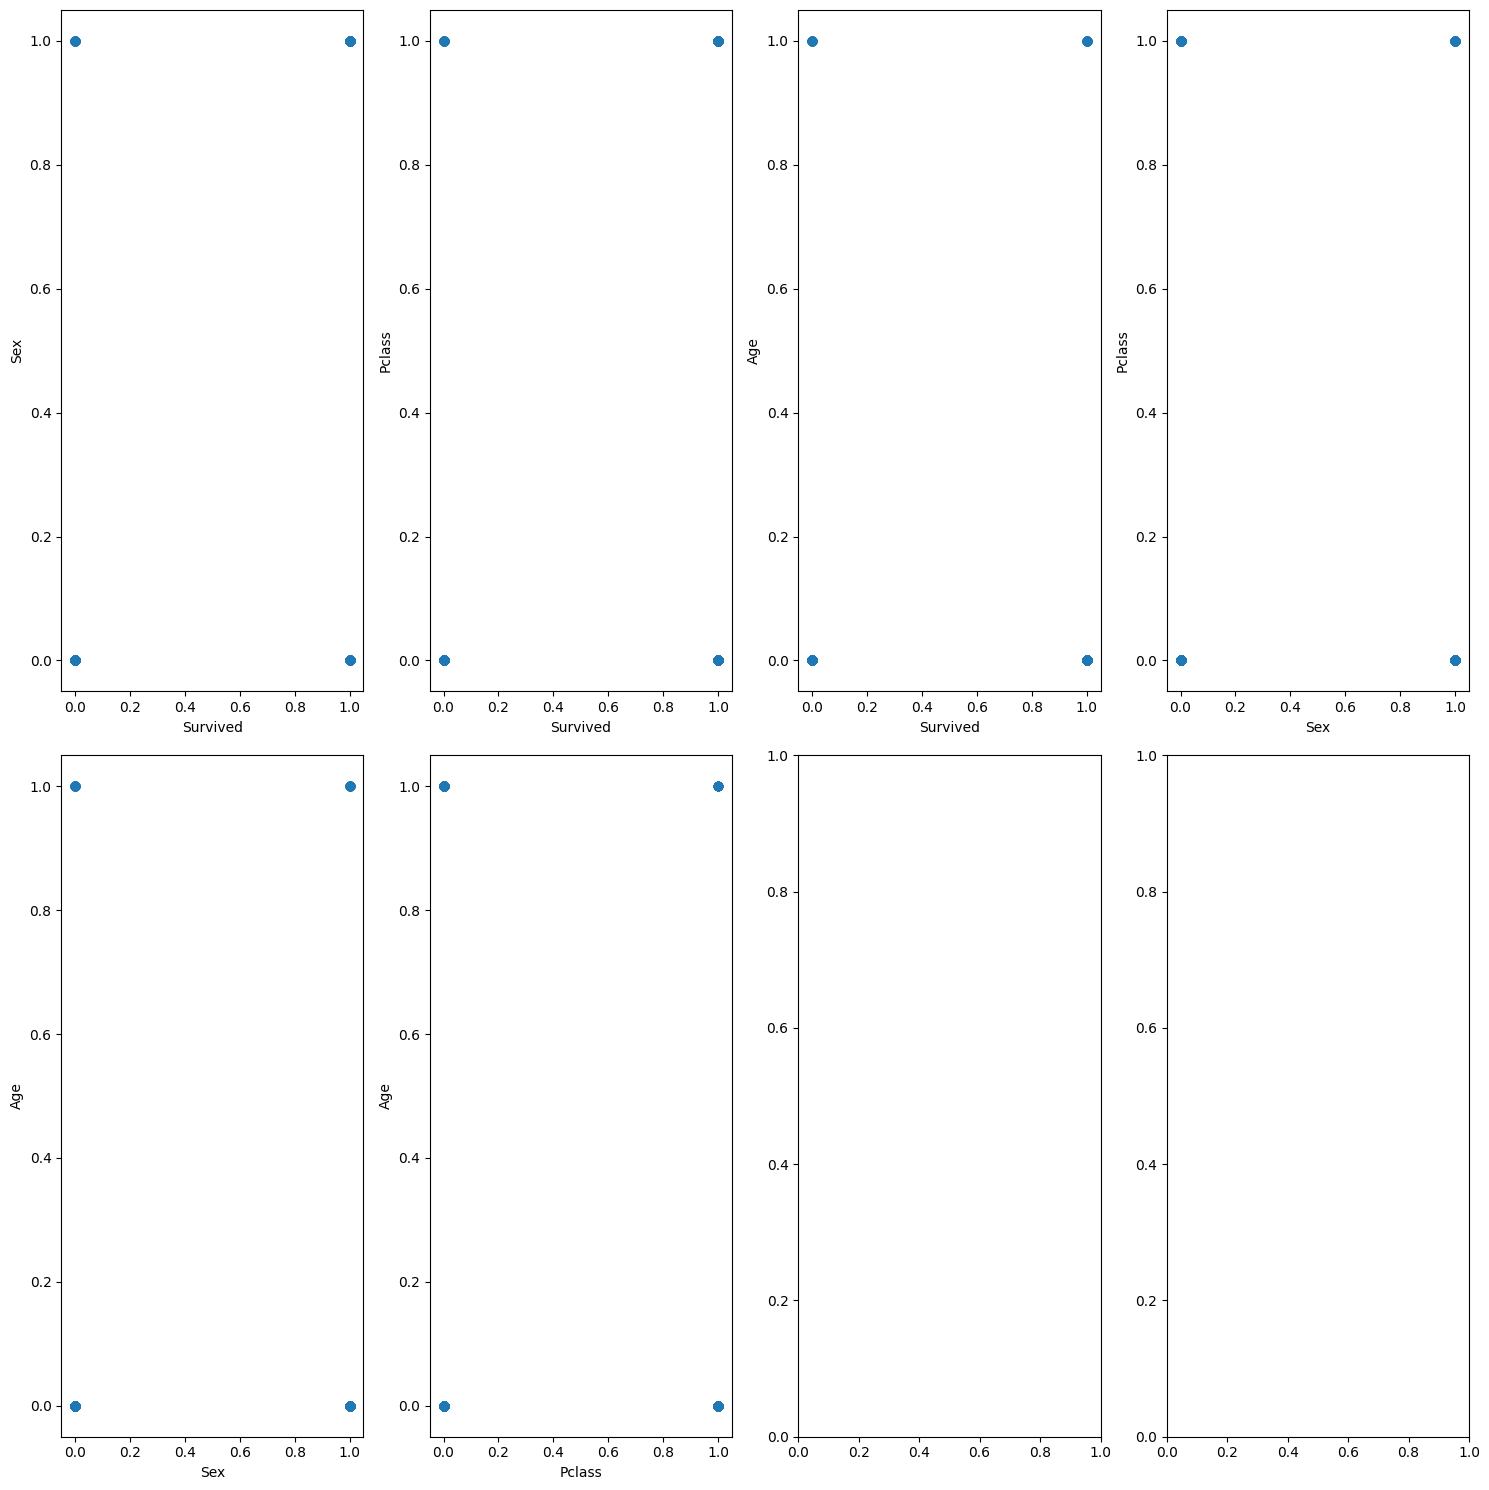

In [448]:
size=len(list(combinations(liste_float_int,2)))
print(size)
fig, axes = plt.subplots(max(size//4,1)+1, 4, figsize=(15, 15))
axes=axes.flatten()
for i, cols in enumerate(combinations(liste_float_int,2)):
  axes[i].scatter(df[cols[0]], df[cols[1]])
  axes[i].set_xlabel(cols[0])
  axes[i].set_ylabel(cols[1])
plt.tight_layout()
plt.show()

**Vérifications des valeurs abérantes**

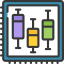

In [449]:
outliers=""
for col in liste_float_int:
  if df[col].nunique()>=5:
    inf=df[col].quantile(0.25)-1.5*iqr(df[col])
    sup=df[col].quantile(0.75)+1.5*iqr(df[col])
    df_outliers=df[(df[col]<inf) | (df[col]>sup)][col]
    outliers=outliers + "la colonne " + col + " contient "+ str(len(df_outliers))+ " outliers pour un iqr de " + str(iqr(df[col])) +'\n'
    df[col]=np.where(df[col]>sup,df[col].mean(),df[col])
    df[col]=np.where(df[col]<inf,df[col].mean(),df[col])
    print(df_outliers)
    print("*"*100)
resume=summary(resume,"EDA","valeurs aberantes avant correction",f"valeurs abérantes :"+"\n" + str(outliers))

In [450]:
outliers=""
for col in liste_float_int:
  if df[col].nunique()>=5:
    inf=df[col].quantile(0.25)-1.5*iqr(df[col])
    sup=df[col].quantile(0.75)+1.5*iqr(df[col])
    df[col]=np.where(df[col]>sup,sup,df[col])
    df[col]=np.where(df[col]<inf,inf,df[col])
    df_outliers=df[(df[col]<inf) | (df[col]>sup)][col]

    if len(df_outliers)>0:
      outliers= outliers + "la colonne " + col + " contient encore  "+ str(len(df_outliers))+ " outliers pour un iqr de " + str(iqr(df[col])) +'\n'
      print(df_outliers)
      print("*"*100)

resume=summary(resume,"EDA","valeurs aberantes après correction",f"valeurs abérantes :"+"\n" + str(outliers))

**Transformation des données catégorielles**

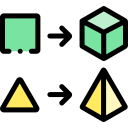

In [451]:
features=df.drop(cible, axis=1)
features=pd.get_dummies(features,columns=liste_cat,dtype=float, drop_first=True)
resume=summary(resume,"Data Preprocessing","transformation des données catégorielles",f"méthode utilisée: pd.get_dummies(...)")

**Division du Dataset**

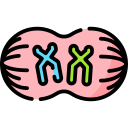

In [452]:
features=features.values
targets=df[cible].values
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=fraction, random_state=seed)
resume=summary(resume,"Modelisation",f"Division en données {features.shape} d'entrainement et de test \n",f"proportion de test {X_test.shape} :{fraction}"+"\n"\
               + f"valeur de reproductibilité :{seed}")

**Standardisation / Normalisation des données**

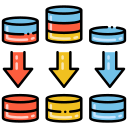

In [453]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
resume=summary(resume,"Data Preprocessing","Standardisation/Normalisation des données",f"méthode utilisée [sklearn]: StandardScaler(...)")

**Initialisation du modèle**

In [454]:
logreg=LogisticRegression(solver='lbfgs', max_iter=100)
resume=summary(resume,"Modelisation","Instanciation du modèle",f"LogisticRegression(...)")

Entrainement du modèle

In [455]:
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
y_pred_proba=logreg.predict_proba(X_test)[:,1]
resume=summary(resume,"Modelisation","Entrainement du modèle",f"LogisticRegression(...)")

Validation des hypothèses

In [456]:
hypotheses="xxx"
resume=summary(resume,"Validation des hypothèses","Validation des hypothèses",hypotheses)

Evaluation du modèle

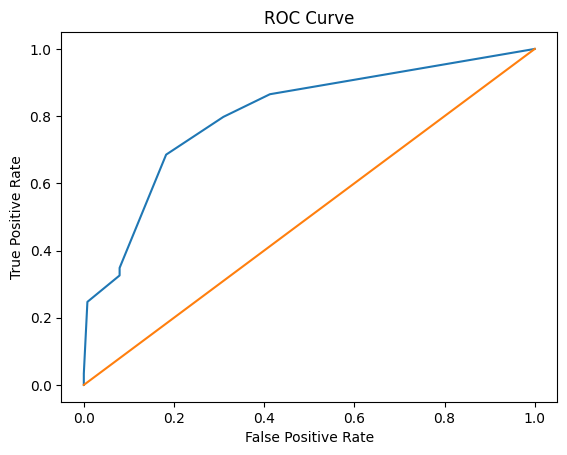

0.8025682182985555


In [457]:
#print(y_pred)
#print(y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
roc_auc = auc(fpr, tpr)
print(roc_auc)
resume=summary(resume,"Evaluation","Precision du modèle",str(round(roc_auc,3)))

Interpretation du résultat

In [458]:
resume=summary(resume,"Inteprétation du résultat","Interprétation :",f" notre modèle a un score de {str(round(roc_auc,3))} ce qui signifie que...")

In [459]:
print_summary(resume)

****************************************************************************************************
================================RESULTATS: analyses et Modélisation=================================
****************************************************************************************************
+-----+---------------------------+---------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------+
|   1 | Section                   | libelle                                                 | information                                                                                                                   |
+=====+===========================+=========================================================+===============================================================================================================================+
|   2 | Dataset                